In [112]:
import numpy as np
import pandas as pd
from datetime import datetime

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import metrics, preprocessing

import tensorflow as tf
from tensorflow.keras import models, layers, utils  

# 1. Loading Data

I will be using data from the [MovieLens dataset](https://grouplens.org/datasets/movielens/latest/). The MovieLens dataset was produced by [GroupLens Research](https://en.wikipedia.org/wiki/GroupLens_Research), a lab out of the University of Minnesota, and is a popular dataset for building movie recommender systems. 

In [113]:
## movies data
movies = pd.read_csv("data/movies.csv")
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [114]:
## user ratings data
ratings = pd.read_csv("data/ratings.csv")
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


# 2. Data Preprocessing and EDA

Initially, I notice that the movieId's start counting from 1 rather than 0. I prefer working with UID's that begin at 0 because it is more compactible with pandas indexing. I am going to reset the movie ID's and assign the new ID's to the <strong>*movie*</strong> column. Next, I will extract the movie's name and year from the <strong>*title*</strong> column and store in their own respective columns. Lastly, let's flag if a movie is made before the year 2000 and assign it the the <strong>*old*</strong> column. We can use this as a possible feature later in out content-based model. This is a good start with the movies dataframe. Let's move onto the ratings dataframe for initial cleaning and preprocessing. 

In [115]:
## Movies
## assign new movie id to "movie"
movies["movie"] = range(0,len(movies))

## extract the movie's name from the "title" column
movies["name"] = movies["title"].str.split(r"(").str[0]

## extract the movie's year from the "title" column
movies["year"] = movies["title"].apply(lambda x: int(x.split(r"(")[-1][0:4]) if r"(" in x else np.nan)

## flag if year is < 2000
movies["old"] = movies["year"].apply(lambda x: 1 if x < 2000 else 0)
movies.head()

,movieId,title,genres,movie,name,year,old
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,0,Toy Story,1995.0,1
1,2,Jumanji (1995),Adventure|Children|Fantasy,1,Jumanji,1995.0,1
2,3,Grumpier Old Men (1995),Comedy|Romance,2,Grumpier Old Men,1995.0,1
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,3,Waiting to Exhale,1995.0,1
4,5,Father of the Bride Part II (1995),Comedy,4,Father of the Bride Part II,1995.0,1


Again, I am going to reset the user's IDs to start with 0 as the first ID and assign to the <strong>*user*</strong> column. Now, let's work with the <strong>*timestamp*</strong> column. The timestamps are currently being stored as integers, converting them to Timestamp objects will allow for easier manipulation and feature engineering. We can now use Timestamp functions to flag whether the movie was watched during the daytime and/or on the weekend. Last thing we need to do is map <strong>*movieID*</strong> to <strong>*movie*</strong> since we are going to be using the reset indices moving forward. 

In [116]:
## ratings
## scale new user id starting at 0 and assign to "user"
ratings["user"] = ratings["userId"].apply(lambda x: x-1)

## converting timestamp int into Timestamp
ratings["timestamp"] = ratings["timestamp"].apply(lambda x: datetime.fromtimestamp(x))

## flagging if timestamp is during the daytime
ratings["daytime"] = ratings["timestamp"].apply(lambda x: 1 if 6<int(x.strftime("%H"))<20 else 0)

## flagging if timestamp is on the weekend
ratings["weekend"] = ratings["timestamp"].apply(lambda x: 1 if x.weekday() in [5,6] else 0)

## adding new movie id column "movie" to ratings df
ratings = ratings.merge(movies[["movieId","movie"]], how="left")

## rename "rating" to "y" (this is our target variable)
ratings = ratings.rename(columns={"rating":"y"})
ratings.head()

,userId,movieId,y,timestamp,user,daytime,weekend,movie
0,1,1,4.0,2000-07-30 11:45:03,0,1,1,0
1,1,3,4.0,2000-07-30 11:20:47,0,1,1,2
2,1,6,4.0,2000-07-30 11:37:04,0,1,1,5
3,1,47,5.0,2000-07-30 12:03:35,0,1,1,43
4,1,50,5.0,2000-07-30 11:48:51,0,1,1,46


Now, we can select the cleaned columns and then jump into some EDA. 

In [117]:
## clean movies
movies = movies[["movie","name","old","genres"]].set_index("movie")
movies.head()

,name,old,genres
movie,,,
0,Toy Story,1,Adventure|Animation|Children|Comedy|Fantasy
1,Jumanji,1,Adventure|Children|Fantasy
2,Grumpier Old Men,1,Comedy|Romance
3,Waiting to Exhale,1,Comedy|Drama|Romance
4,Father of the Bride Part II,1,Comedy


In [118]:
## clean users
ratings = ratings[["user","movie","daytime","weekend","y"]]
ratings.head()

,user,movie,daytime,weekend,y
0,0,0,1,1,4.0
1,0,2,1,1,4.0
2,0,5,1,1,4.0
3,0,43,1,1,5.0
4,0,46,1,1,5.0


About 68% of the movies in our dataset were watched during the daytime and about 70% of the movies were watched during on a weekday (<strong>*daytime*</strong> and <strong>*weekend*</strong> are independent variables). I won't be using either feature in the models, so let's save the to a <strong>*reference*</strong> dataframe. 

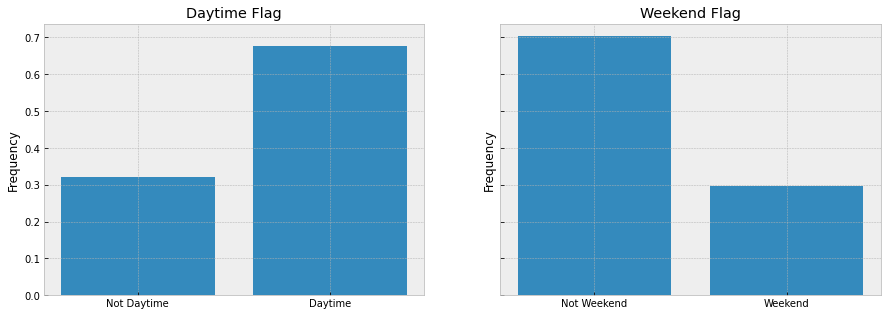

In [119]:
## daytime and weekend frequency
daytime = ratings.groupby("daytime").count().reset_index()[["daytime", "y"]].rename(columns={"y":"count"})
daytime["frequency"] = daytime["count"]/sum(daytime["count"])
daytime["daytime"] = daytime["daytime"].apply(lambda x: "Daytime" if x == 1 else "Not Daytime")
daytime

weekend = ratings.groupby("weekend").count().reset_index()[["weekend", "y"]].rename(columns={"y":"count"})
weekend["frequency"] = weekend["count"]/sum(weekend["count"])
weekend["weekend"] = weekend["weekend"].apply(lambda x: "Weekend" if x == 1 else "Not Weekend")
weekend

fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(15,5))
ax[0].set(title="Daytime Flag")
ax[0].bar(daytime["daytime"], daytime["frequency"])
ax[0].set_ylabel('Frequency', color='black')
ax[1].set(title="Weekend Flag")
ax[1].bar(weekend["weekend"], weekend["frequency"])
ax[1].set_ylabel('Frequency', color='black');

In [120]:
## reference 
reference = ratings[["user","movie","daytime","weekend"]]
reference.head()

,user,movie,daytime,weekend
0,0,0,1,1
1,0,2,1,1
2,0,5,1,1
3,0,43,1,1
4,0,46,1,1


Now it's time to better understand our users. Let's see how many movies each of our users have watched and what each of their average ratings are.

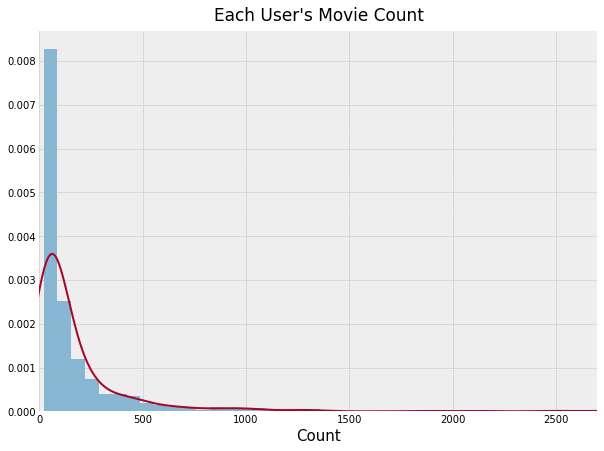

In [121]:
## How many movies has each user's watched?
user_counts = ratings.groupby("user").count()["y"]
user_counts

## plot the distribution of each user's movie count
fig, ax = plt.subplots(figsize = (10,7))

user_counts.plot(kind = "hist", density = True, alpha = 0.55, bins = 40) 
user_counts.plot(kind = "kde")
plt.style.use("bmh")

ax.set_xlabel("Count", size=15)
ax.set_xlim(0, 2700)
ax.set_ylabel("")

ax.set_title("Each User's Movie Count", size = 17, pad = 10)
ax.tick_params(left = False, bottom = False)
for ax, spine in ax.spines.items():
    spine.set_visible(False)
plt.show()

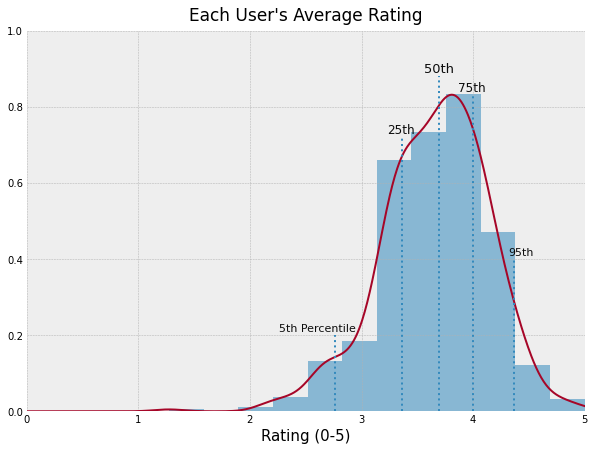

In [122]:
## What is each user's average rating?
avg_user_rating = ratings.groupby("user").mean()["y"]
avg_user_rating

## plot the distribution of each user's average rating
fig, ax = plt.subplots(figsize = (10,7))

avg_user_rating.plot(kind = "hist", density = True, alpha = 0.55, bins = 12) 
avg_user_rating.plot(kind = "kde")
plt.style.use("bmh")

# add percentiles
quant_5, quant_25, quant_50, quant_75, quant_95 = avg_user_rating.quantile(0.05), avg_user_rating.quantile(0.25), avg_user_rating.quantile(0.5), avg_user_rating.quantile(0.75), avg_user_rating.quantile(0.95)
quants = [[quant_5, 1, 0.20], [quant_25, 1, 0.72], [quant_50, 1, 0.88],  [quant_75, 1, 0.83], [quant_95, 1, 0.40]]
for i in quants:
    ax.axvline(i[0], alpha = i[1], ymax = i[2], linestyle = ":")
    
ax.text(quant_5-.5, 0.21, "5th Percentile", size = 11, alpha = 0.95)
ax.text(quant_25-.13, 0.73, "25th", size = 12, alpha = 0.95)
ax.text(quant_50-.13, 0.89, "50th", size = 13, alpha = 0.95)
ax.text(quant_75-.13, 0.84, "75th", size = 12, alpha = 0.95)
ax.text(quant_95-.05, 0.41, "95th", size = 11, alpha =.95)

ax.set_xlabel("Rating (0-5)", size=15)
ax.set_xlim(0, 5)
ax.set_ylim(0,1)
ax.set_ylabel("")

ax.set_title("Each User's Average Rating", size = 17, pad = 10)
ax.tick_params(left = False, bottom = False)
for ax, spine in ax.spines.items():
    spine.set_visible(False)
plt.show()

As seen above, most of our users have seen only a small fraction of the movies in our dataset. Let's visualise how sparse the data is with a heatmap.

In [123]:
## Create Users x Movies dataframe
users_tmp = ratings.copy()
users_movies = users_tmp.pivot(index="user", columns="movie", values="y")

missing_cols = list(set(movies.index) - set(users_movies.columns))
for col in missing_cols:
    users_movies[col] = np.nan
users_movies = users_movies[sorted(users_movies.columns)]

users_movies

movie,0,1,2,3,4,5,6,7,8,9,...,9732,9733,9734,9735,9736,9737,9738,9739,9740,9741
user,,,,,,,,,,,,,,,,,,,,,
0,4.0,NaN,4.0,NaN,NaN,4.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
605,2.5,NaN,NaN,NaN,NaN,NaN,2.5,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
606,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
607,2.5,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


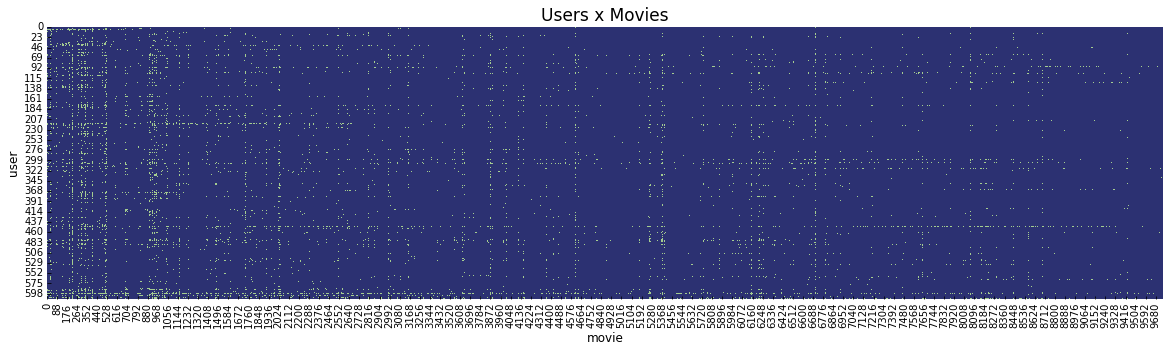

In [124]:
## How sparse is our Users X Movies data?
fig, ax = plt.subplots(figsize=(20,5))
sns.heatmap(users_movies.isnull(), vmin=0, vmax=1, cbar=False, cmap='crest', ax=ax).set_title("Users x Movies", size=17)
plt.show()

In [125]:
## pause

In [63]:
## Create Movies x Features dataframe
movies_features = pd.DataFrame({"old":movies["old"]})


## One-Hot-Encode genres
genres = list(movies["genres"].str.split(r"|"))
temp = genres[0]
for i in range(1, len(genres)):
    temp.extend(genres[i])

new_cols = list(set(temp))
new_cols.remove("(no genres listed)")
for col in new_cols:
    movies_features[col] = movies["genres"].str.contains(col).astype(int)
movies_features.head()

,old,Action,Sci-Fi,Adventure,Film-Noir,Documentary,Mystery,Thriller,Fantasy,War,Romance,Drama,Children,Crime,Horror,Western,IMAX,Animation,Musical,Comedy
movie,,,,,,,,,,,,,,,,,,,,
0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,1
1,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1
3,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1
4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [64]:

## scale all ratings between 0.5 and 1
users_movies = pd.DataFrame(preprocessing.MinMaxScaler(feature_range=(0.5,1)).fit_transform(users_movies.values), columns=users_movies.columns, index=users_movies.index)
users_movies

/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:461: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:462: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)


movie,0,1,2,3,4,5,6,7,8,9,...,9732,9733,9734,9735,9736,9737,9738,9739,9740,9741
user,,,,,,,,,,,,,,,,,,,,,
0,0.888889,NaN,0.888889,NaN,NaN,0.875,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.888889,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
605,0.722222,NaN,NaN,NaN,NaN,NaN,0.6875,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
606,0.888889,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
607,0.722222,0.666667,0.666667,NaN,NaN,NaN,NaN,NaN,NaN,0.888889,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Understanding the Data

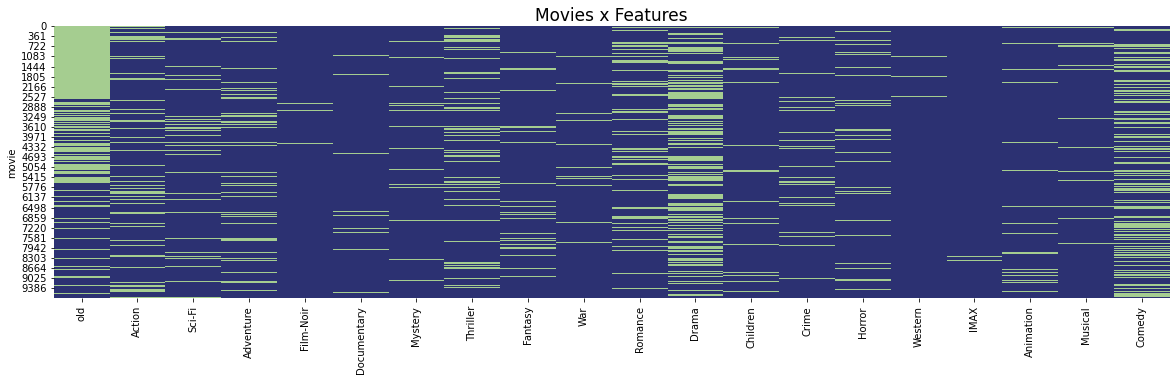

In [65]:
## heatmap: Movies x Features
fig, ax = plt.subplots(figsize=(20,5))
sns.heatmap(movies_features==0, vmin=0, vmax=1, cbar=False, cmap='crest', ax=ax).set_title("Movies x Features", size=17)
plt.show()

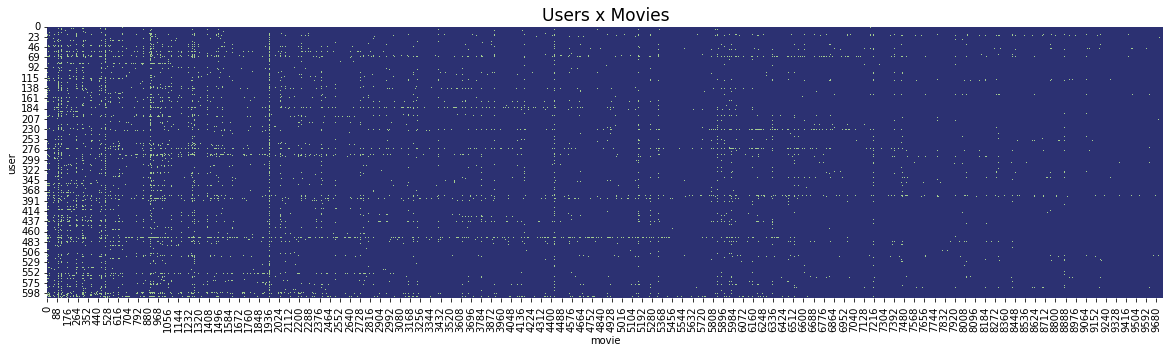

# Start Content Based Model

# Train and Test Split

In [67]:
## Represent all users in both train and test dataframes
## Include 80% of movies in train dataframe and 20% in test dataframe

## split users x movies df vertically at 80/20 split
split = int(0.8*users_movies.shape[1])
users_movies_train = users_movies.loc[:, :split-1]
users_movies_test = users_movies.loc[:, split:]
print("---Train and Test Shapes---")
print("Users x Movies Train: ", users_movies_train.shape)
print("Users x Movies Test: ", users_movies_test.shape)

## split movies x features df horizontally at 80/20 split 
split = int(0.8*users_movies.shape[1])
movies_features_train = movies_features.loc[:split-1, :]
movies_features_test = movies_features.loc[split:, :]

print("Movies x Features Train: ", movies_features_train.shape)
print("Movies x Features Test: ", movies_features_test.shape)

---Train and Test Shapes---
Users x Movies Train:  (610, 7793)
Users x Movies Test:  (610, 1949)
Movies x Features Train:  (7793, 20)
Movies x Features Test:  (1949, 20)


In [68]:
def trainContestBasedRecommender(users_movies_df, movies_features_df):
    """
    Returns users x features weightings.
    args:
        users_movies_df [(int) x, (int) z]: users x movies true rating 
        movies_features_df [(int) z, (int) y]: one-hot movies x features matrix
    returns:
        model [(int) x, (int) y]: users x features weightings 
    """
    users_movies_df = users_movies_df.fillna(0)
    users_features_df = tf.matmul(users_movies_df, movies_features_df)
    return users_features_df / tf.reduce_sum(users_features_df, axis=1, keepdims=True)

def applyContentBasedRecommender(model, movies_features_df):
    """
    Returns user x movie recommendations.
    args:
        model [(int) x, (int) y]: users x features weightings
        movies_features_df [(int) z, (int) y]: one-hot movies x features matrix
    returns:
        ret [(int) x, (int) z]: users x movies recommendations scaled between 0-1
    """
    return tf.matmul(model, movies_features_df.T)


In [69]:
## train
model = trainContestBasedRecommender(users_movies_train, movies_features_train)

## test
test_yhat = applyContentBasedRecommender(model, movies_features_test)
test_yhat

<tf.Tensor: shape=(610, 1949), dtype=float64, numpy=
array([[0.07454613, 0.15424348, 0.08854796, ..., 0.07454613, 0.12931799,
        0.33448968],
       [0.21121841, 0.27536086, 0.0985726 , ..., 0.21121841, 0.1561904 ,
        0.15042862],
       [0.0845035 , 0.16901748, 0.05281469, ..., 0.0845035 , 0.12793939,
        0.31044348],
       ...,
       [0.10222328, 0.20004054, 0.11802327, ..., 0.10222328, 0.12119651,
        0.30401361],
       [0.14758239, 0.19993237, 0.05453786, ..., 0.14758239, 0.09384013,
        0.34075223],
       [0.12408448, 0.24373979, 0.10558504, ..., 0.12408448, 0.13569929,
        0.19636865]])>

In [ ]:
test_eval = users_movies_test.stack(dropna=False).reset_index().rename({0:"y"}, axis=1)
test_yhat_stacked = pd.DataFrame(test_yhat.numpy()).stack().reset_index().rename({0:"yhat"}, axis=1)
test_eval = pd.concat([test_eval, test_yhat_stacked], axis=1)
test_eval = test_eval.drop(["level_0", "level_1"], axis=1)
test_eval = test_eval[~test_eval["y"].isna()]
test_eval

In [102]:
# Evaluate
def mean_reciprocal_rank(y_test, predicted):
    score = []
    for product in y_test:
        mrr = 1 / (list(predicted).index(product) + 1) if product in predicted else 0
        score.append(mrr)
    return np.mean(score)

In [103]:
# single case
i = 1
print("--- user", i, "---")

top = 5
y_test = test_eval[test_eval["user"]==i].sort_values("y", ascending=False)["movie"].values[:top]
print("y_test:", y_test)

predicted = test_eval[test_eval["user"]==i].sort_values("yhat", ascending=False)["movie"].values[:top]
print("predicted:", predicted)

true_positive = len(list(set(y_test) & set(predicted)))
print("true positive:", true_positive, "("+str(round(true_positive/top*100,1))+"%)")
print("accuracy:", str(round(metrics.accuracy_score(y_test,predicted)*100,1))+"%")
print("mrr:", round(mean_reciprocal_rank(y_test, predicted),2))

--- user 1 ---
y_test: [8305 8681 8466 8550 8063]
predicted: [8509 8305 8063 8550 8681]
true positive: 4 (80.0%)
accuracy: 20.0%
mrr: 0.26


In [105]:
## averages for all users

true_positives = []
accuracy = []
mrr = []

for i in np.unique(test_eval["user"]):
    top = 10
    y_test_eval = test_eval[test_eval["user"]==i].sort_values("y", ascending=False)["movie"].values[:top]
    predicted = test_eval[test_eval["user"]==i].sort_values("yhat", ascending=False)["movie"].values[:top]
    true_positive = len(list(set(y_test_eval) & set(predicted)))
    true_positives.append(true_positive)
    accuracy.append(metrics.accuracy_score(y_test_eval,predicted))
    mrr.append(mean_reciprocal_rank(y_test_eval, predicted))

    
print("--- evaluation of test_eval users' top 5 predicted movies ---")
print("avg true positive:", np.mean(true_positives), "("+str(round(np.mean(true_positives)/top*100,1))+"%)")
print("avg accuracy:", str(round(np.mean(accuracy)*100,1))+"%")
print("avg mrr:", round(np.mean(mrr),2))    

--- evaluation of test_eval users' top 5 predicted movies ---
avg true positive: 3.935828877005348 (39.4%)
avg accuracy: 20.1%
avg mrr: 0.33


In [106]:
## DONE

,user,movie,y,yhat
2219,1,8063,0.812500,0.367409
2461,1,8305,1.000000,0.446949
2532,1,8376,0.777778,0.071390
2622,1,8466,0.875000,0.211218
2665,1,8509,0.500000,0.467547
...,...,...,...,...
1188582,609,9434,0.937500,0.313704
1188609,609,9461,1.000000,0.313408
1188610,609,9462,1.000000,0.065535
1188611,609,9463,1.000000,0.176208


In [87]:
# overall
y_test = test_eval["y"]
predicted = test_eval["yhat"]

print("Mean Absolute Error (Σ|y-pred|/n):", "{:,.0f}".format(metrics.mean_absolute_error(y_test, predicted)))
print("Mean Absolute Perc Error (Σ(|y-pred|/y)/n):", str(round(np.mean(np.abs((y_test-predicted)/predicted)), 2))+"%")

Mean Absolute Error (Σ|y-pred|/n): 1
Mean Absolute Perc Error (Σ(|y-pred|/y)/n): inf%


In [100]:
sum(np.abs((y_test - predicted)/ predicted) == np.inf)

65

In [52]:
# # overall
# y_test = train_eval["y"]
# predicted = train_eval["yhat"]

# print("Mean Absolute Error (Σ|y-pred|/n):", "{:,.0f}".format(metrics.mean_absolute_error(y_test, predicted)))
# print("Mean Absolute Perc Error (Σ(|y-pred|/y)/n):", str(round(np.mean(np.abs((y_test-predicted)/predicted)), 2))+"%")

In [53]:
# train_yhat_stacked = pd.DataFrame(train_yhat.numpy()).stack().reset_index().rename({0:"yhat"}, axis=1)

In [54]:
# train_yhat_stacked

In [1172]:
def unseenMovies(users_movies_df):
    """
    Returns a dictionary of each user's unseen movies.
    args:
        users_movies_df [(int) x, (int) z]: users x movies rating (null indicates unseen)
    returns:
        unseen_dict {user1: [movie1, movie2, ...], ...}: each user's unseen movies
    """
    unseen_dict = {}
    for user in range(len(users_movies_df)): 
        obs = users_movies_df.iloc[user, :]
        unseen_movies = obs[obs.isna()].index
        unseen_dict[user] = unseen_movies
    return unseen_dict

    

def hitRatio(y, yhat, unseen_dict, threshold=10):
    """
    Evaluates model's predictions based on hit ratio algorithm.
    args:
        y [(int) x, (int) z]: true users x movies rating matrix
        yhat [(int) x, (int) z]: model's prediction of users x movies rating matrix
        unseen_dict {user1: [movie1, movie2, ...], ...}: each user's unseen movies
        threshold (int) k: threshold that defines a hit prediction 
    returns:
        hit ratio: hit ratio @ threshold
    """
    hit = []
    interaction_pairings = y.stack(dropna=True).reset_index()
    movie_index_map = dict(zip(y.columns, range(y.shape[1])))
    for pair in range(len(interaction_pairings)):
        u = interaction_pairings.iloc[pair, 0]
        m = interaction_pairings.iloc[pair, 1]
        random_99_unseen = np.random.choice(unseen_dict[u], size=99, replace=False)
        hit_check_movies = np.append(random_99_unseen, m)
        hit_check_indices = [movie_index_map[movie] for movie in hit_check_movies]
        predictions = tf.gather(yhat[u], indices = hit_check_indices)
        df = pd.DataFrame({"movie": hit_check_movies, "yhat": predictions})
        top_preds = df.sort_values("yhat", ascending=False).iloc[:threshold, :]["movie"]
        if m in list(top_preds):
            hit.append(1)
        else:
            hit.append(0)
    return np.mean(hit)

In [ ]:
## Hit Ratio for train dataset
train_hit_ratio = hitRatio(users_movies_train, train_yhat, unseenMovies(users_movies_train), 15)
print("Train hit ratio: ", train_hit_ratio)

In [ ]:
## Apply model to test df
test_yhat = applyContentBasedRecommender(users_features_df, movies_features_test)
test_yhat

In [ ]:
## Hit Ratio for test dataset
test_hit_ratio = hitRatio(users_movies_test, test_yhat, unseenMovies(users_movies_test), 15)
print("Test hit ratio: ", test_hit_ratio)